In [1]:
from matplotlib import pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
from torch_geometric.data import DataLoader

import os
import numpy as np
import pandas as pd

from ogb.nodeproppred import PygNodePropPredDataset
from ogb.linkproppred import PygLinkPropPredDataset

from ogb.graphproppred import PygGraphPropPredDataset

cwd = os.getcwd()
os.chdir('/home/sandbox/workspace/causal_attn')

from models import *
from utils import *
from train import *
from run import instantiate_model
from evaluations import *

os.chdir(cwd)

## Dataset Statistics

In [2]:
from torch_geometric.utils import homophily

for dataset_name in ['Cora','CiteSeer','PubMed','ogbn-arxiv']:
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  
  print(dataset_name,'-----',homophily(test_loader.data.edge_index,test_loader.data.y))
  
print('=======')

for dataset_name in ['squirrel','chameleon','cornell','texas','wisconsin']:
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=0)
  
  print(dataset_name,'-----',homophily(test_loader.data.edge_index,test_loader.data.y))

Cora ----- 0.8099659085273743
CiteSeer ----- 0.7355008721351624
PubMed ----- 0.8023869395256042
ogbn-arxiv ----- 0.6550830602645874
squirrel ----- 0.22344225645065308
chameleon ----- 0.23394635319709778
cornell ----- 0.12203390151262283
texas ----- 0.06148867309093475
wisconsin ----- 0.17034068703651428


In [3]:
from torch_geometric.utils import degree

for dataset_name in ['Cora','CiteSeer','PubMed','ogbn-arxiv']:
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  
  print(dataset_name,'-----',degree(train_loader.data.edge_index[1]).mean().data.numpy())
  
print('=======')

for dataset_name in ['squirrel','chameleon','cornell','texas','wisconsin']:
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=0)
  
  print(dataset_name,'-----',degree(train_loader.data.edge_index[1]).mean().data.numpy())

Cora ----- 3.8980799
CiteSeer ----- 2.7363992
PubMed ----- 4.496019
ogbn-arxiv ----- 6.8869095
squirrel ----- 41.70986
chameleon ----- 15.832675
cornell ----- 1.6120218
texas ----- 1.6978022
wisconsin ----- 1.996


In [4]:
# base_results_df = results_df[results_df['base']]
# eval_results_df = results_df[~results_df['base']]

# for model,base_model_df in base_results_df.groupby('model'):
#   base_model_df[(base_model_df['set'] == 'valid')].sort_values('acc',ascending=False)
#   base_model_df.index = base_model_df['params'] + '.nl' + base_model_df['n_layers'].astype(str)
  
#   eval_model_df = eval_results_df[(eval_results_df['model'] == model) & (eval_results_df['set'] == 'test')]
#   eval_model_df.index = eval_model_df['params'] + '.nl' + eval_model_df['n_layers'].astype(str)
#   eval_model_df = eval_model_df.loc[base_model_df.index.values]
  
#   print(model.split('.')[0],'----------')
#   print(base_model_df['acc'].values[0:5],eval_model_df['acc'].values[0:5])

## Planetoid

=====   Cora   =====


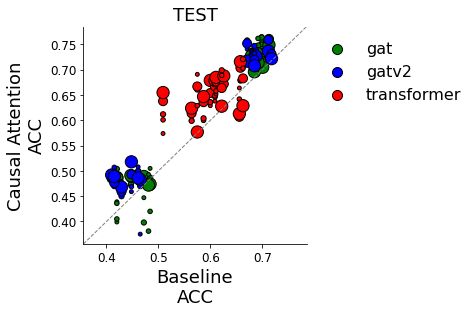

WilcoxonResult(statistic=1205.5, pvalue=2.908896497247298e-23) 		 0.03780555555555556 0.035323105139170224
=====   CiteSeer   =====


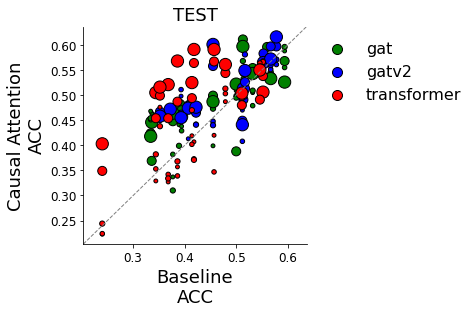

WilcoxonResult(statistic=3858.5, pvalue=4.5835289892807967e-10) 		 0.03412222222222222 0.06208146167176073
=====   PubMed   =====


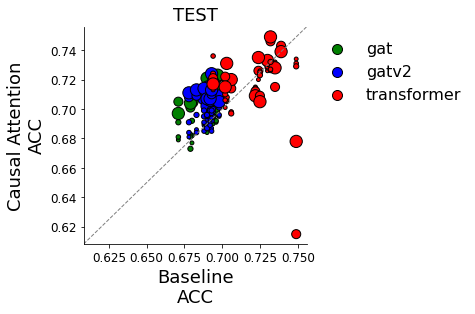

WilcoxonResult(statistic=3381.5, pvalue=6.097791717137948e-11) 		 0.006155555555555557 0.017049327784458956


In [10]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep400.early_stop.ratio'
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,50,100,200][3:],
                 'lc': [0.1,0.5,1.0,5.0,10.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=0,suffix=suffix,task=task)
    results_df.to_csv(results_path,sep='\t')

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
    filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] >= 1]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] >= 0) | (filtered_results_df['lc'] == 0)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

=====   Cora   =====


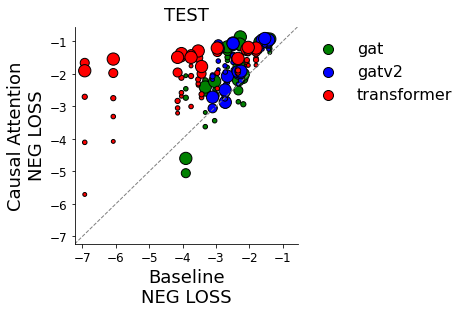

WilcoxonResult(statistic=559.0, pvalue=1.1556396664776983e-27) 		 0.8769577156666666 0.9504743695626788
=====   CiteSeer   =====


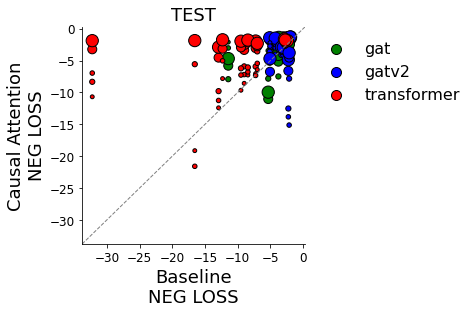

WilcoxonResult(statistic=3198.0, pvalue=7.93145858944656e-13) 		 1.951488583888889 5.412428325886796
=====   PubMed   =====


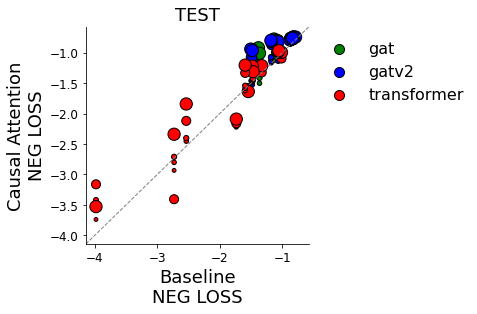

WilcoxonResult(statistic=2596.0, pvalue=1.1254315739240315e-15) 		 0.09351555649999997 0.20034092008963597


In [47]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep400.early_stop.ratio'
  device = 0
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  dim_in,dim_out,edge_dim,pred_criterion = get_dataset_params(dataset_name,train_loader,10)
  
  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,50,100,200][3:],
                 'lc': [0.1,0.5,1.0,5.0,10.0][-3:],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models_loss(dataset_name,valid_loader,test_loader,pred_criterion,save_dir,params_dict,
                                      device=device,suffix=suffix,task=task)
    results_df.to_csv(results_path,sep='\t')
  
  results_df['neg loss'] = -results_df['loss']
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison_loss.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='neg loss',
                               alpha_feat='lc',save_path=plot_path)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

=====   Cora   =====
t-test: Ttest_indResult(statistic=-2.7189633025402142, pvalue=0.003814791811778995)
-0.6672458875 0.6266006193474595
-1.0946646419444446 1.1775420115794941


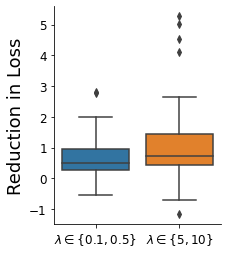

=====   CiteSeer   =====
t-test: Ttest_indResult(statistic=-2.038071391069738, pvalue=0.021742652383483274)
-1.1643904694444442 4.794509691729813
-3.0025474041666667 5.964936993642652


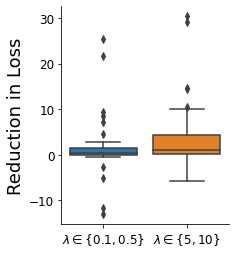

=====   PubMed   =====
t-test: Ttest_indResult(statistic=-5.018728937794564, pvalue=9.378148762219333e-07)
-0.019964808472222203 0.14440961308978123
-0.18448396347222223 0.23773266191882628


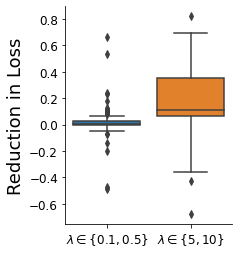

In [12]:
from ogb.nodeproppred import Evaluator
from scipy.stats import ttest_ind

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))

  suffix = 'interv.dataloader.ep400.early_stop.ratio'

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  results_df = pd.read_csv(results_path,sep='\t')

  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','loss']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  eval_set = 'test'
  filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='loss',
                             alpha_feat='lc',save_path=None,plot=False)
  
  plot_df_lc_high = plot_df[plot_df['lc'] > 1]
  plot_df_lc_low = plot_df[plot_df['lc'] < 1]
  
  delta_lc_low = plot_df_lc_low['x']-plot_df_lc_low['y']
  delta_lc_high = plot_df_lc_high['x']-plot_df_lc_high['y']
    
  box_df = pd.DataFrame({'values': np.concatenate([delta_lc_low,delta_lc_high],axis=0)})
  
  box_df['category'] = [r'$\lambda \in \{0.1,0.5\}$']*len(delta_lc_low) + [r'$\lambda \in \{5,10\}$']*len(delta_lc_high)
  
  print('t-test:',ttest_ind(delta_lc_low,delta_lc_high,alternative='less',equal_var=False))

  print((plot_df_lc_low['y']-plot_df_lc_low['x']).mean(),(plot_df_lc_low['y']-plot_df_lc_low['x']).std())
  print((plot_df_lc_high['y']-plot_df_lc_high['x']).mean(),(plot_df_lc_high['y']-plot_df_lc_high['x']).std())
  
  plt.figure(figsize=(3,4))
  sns.boxplot(x='category',y='values',data=box_df)

  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('')
  plt.ylabel('Reduction in Loss',fontsize=18)
  sns.despine()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  save_path = os.path.join(plot_dir,'lambda_compare_loss.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  plt.savefig(save_path,dpi=500,bbox_inches='tight')
  
  plt.show()

### vs. Label Propagation vs. Random

In [55]:
lc_thresh = 5

eval_metric = 'acc'
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep400.early_stop.ratio'

for dataset_name in ['Cora','CiteSeer','PubMed']:

  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,base_suffix))
  causal_df = pd.read_csv(results_path,sep='\t')
  causal_df['category'] = 'causal'
  causal_df = causal_df[causal_df['set'] == 'test']
  causal_df = causal_df[causal_df['lc'] >= lc_thresh]

  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,base_suffix + '.labelprop'))
  labelprop_df = pd.read_csv(results_path,sep='\t')
  labelprop_df['category'] = 'labelprop'
  labelprop_df = labelprop_df[labelprop_df['set'] == 'test']
  labelprop_df = labelprop_df[labelprop_df['lc'] >= lc_thresh]
  
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,base_suffix + '.shuffle.rand.unif'))
  random_df = pd.read_csv(results_path,sep='\t')
  random_df['category'] = 'random'
  random_df = random_df[random_df['set'] == 'test']

  random_df = random_df[random_df['lc'] >= lc_thresh]
  
  print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',wilcoxon(causal_df['loss'],labelprop_df['loss'],alternative='less')[1])
  print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',wilcoxon(causal_df['loss'],random_df['loss'],alternative='less')[1])

  print('================================')

Cora    	 Causal vs. LabelProp (loss): p  =  1.0000167763772339e-05
Cora    	 Causal vs. Random (loss): p  =  0.0002514096742205363
CiteSeer    	 Causal vs. LabelProp (loss): p  =  0.01451979162753939
CiteSeer    	 Causal vs. Random (loss): p  =  0.9983318083751577
PubMed    	 Causal vs. LabelProp (loss): p  =  0.0009213163756167698
PubMed    	 Causal vs. Random (loss): p  =  0.0001679767735256996


## ogbn-arxiv

=====   ogbn-arxiv   =====


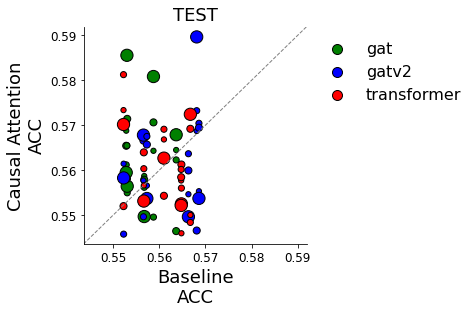

WilcoxonResult(statistic=1105.0, pvalue=0.12042827141198859) 		 0.0016816111796833773 0.011350546661841824


In [66]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device = 0
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=device,suffix=suffix,task=task)
    results_df.to_csv(results_path,sep='\t')
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[(results_df['dim_hidden'] >= 100) & ((results_df['lc'] == 0) | (results_df['lc'] >= 0.))]
    filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] == 1]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

=====   ogbn-arxiv   =====


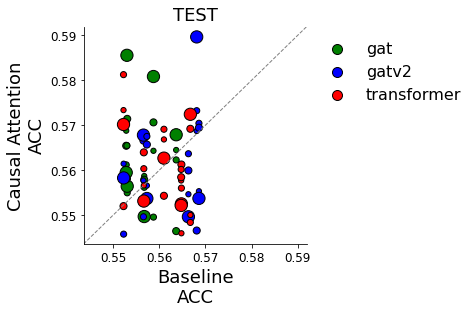

WilcoxonResult(statistic=1105.0, pvalue=0.12042827141198859) 		 0.0016816111796833773 0.011350546661841824


In [65]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device = 0
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=device,suffix=suffix,task=task)
    results_df.to_csv(results_path,sep='\t')
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[(results_df['dim_hidden'] >= 100) & ((results_df['lc'] == 0) | (results_df['lc'] >= 0.))]
    filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] == 1]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

=====   ogbn-arxiv   =====


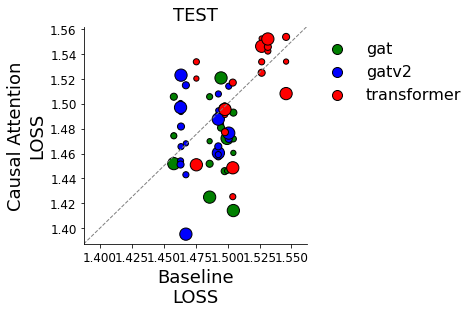

WilcoxonResult(statistic=1690.0, pvalue=0.017429317900981442) 		 -0.008434783333333341 0.03164352619384958


In [68]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device = 1
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  dim_in,dim_out,edge_dim,pred_criterion = get_dataset_params(dataset_name,train_loader,10)
  
  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,50,100,200][3:],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models_loss(dataset_name,valid_loader,test_loader,pred_criterion,save_dir,params_dict,
                                      device=device,suffix=suffix,task=task)
    results_df.to_csv(results_path,sep='\t')

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison_loss.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
    filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] == 1]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 0)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='loss',
                               alpha_feat='lc',save_path=plot_path)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='greater'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

## Wikipedia

=====   chameleon   =====


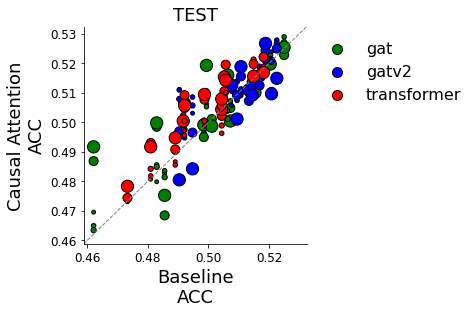

WilcoxonResult(statistic=5116.0, pvalue=2.6290903822601218e-05) 		 0.0023769493177387933 0.006898234304354497
=====   squirrel   =====


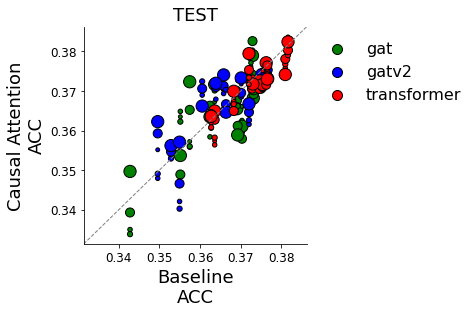

WilcoxonResult(statistic=9319.0, pvalue=0.9656780287380973) 		 -0.0003452876507631569 0.0051719696445432


In [18]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['chameleon','squirrel'][0:2]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep100.early_stop.ratio.labelprop'
  device=0
  n_splits = 10

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,100,200][0:2],
                 'lc': [0.1,0.5,1.0,5.0,10.0][:],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(n_splits):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] <= 25]
    # filtered_results_df = filtered_results_df[filtered_results_df['heads'] == 3]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] >= 0) | (filtered_results_df['lc'] >= 1)]
    filtered_results_df = filtered_results_df[filtered_results_df['n_layers'] >= 1]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # plot_df['y-x'] = plot_df['y']-plot_df['x']
    # print(plot_df.groupby('model')['y-x'].mean())
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

=====   chameleon   =====


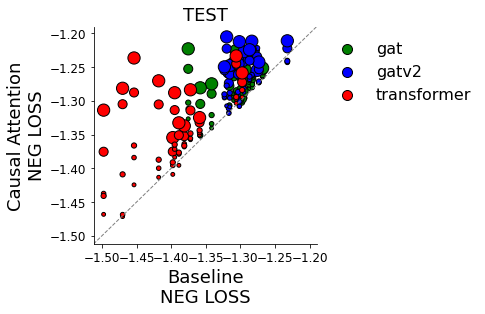

WilcoxonResult(statistic=378.0, pvalue=6.628305218378061e-29) 		 0.03539655000000002 0.04024038423679224
=====   squirrel   =====


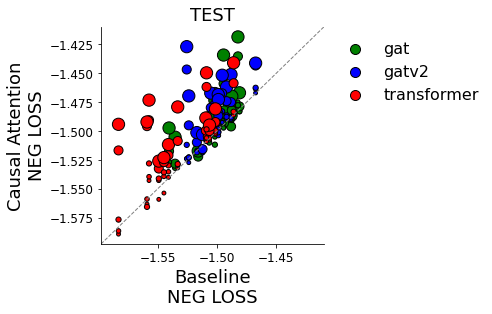

WilcoxonResult(statistic=2342.0, pvalue=5.685623807083375e-17) 		 0.012723519944444458 0.02024217293953991


In [5]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['chameleon','squirrel']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep100.early_stop.ratio.labelprop'
  device=0
  n_splits = 10

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,100,200][0:2],
                 'lc': [0.1,0.5,1.0,5.0,10.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(n_splits):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      dim_in,dim_out,edge_dim,pred_criterion = get_dataset_params(dataset_name,train_loader,10)

      results_df = evaluate_models_loss(dataset_name,valid_loader,test_loader,pred_criterion,save_dir,params_dict,
                                      device=device,suffix=suffix + '.{}'.format(split_no),task=task)

      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','loss']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  results_df['neg loss'] = -results_df['loss']
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'comparison_loss.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 10]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='neg loss',
                               alpha_feat='lc',save_path=plot_path)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

=====   chameleon   =====
t-test: Ttest_indResult(statistic=-9.503490533650712, pvalue=2.333620059338775e-15)
-0.01115854916666667 0.014896694329842333
-0.06493526555555555 0.045645739036145626


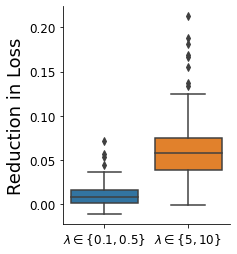

=====   squirrel   =====
t-test: Ttest_indResult(statistic=-9.492022289240744, pvalue=6.413469121710181e-15)
-0.001429853750000006 0.005186067116278475
-0.029212419861111116 0.024288402635710873


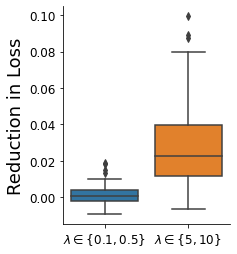

In [4]:
from ogb.nodeproppred import Evaluator
from scipy.stats import ttest_ind

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['chameleon','squirrel'][0:2]:
  print('=====   {}   ====='.format(dataset_name))

  suffix = 'interv.dataloader.ep100.early_stop.ratio'

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  results_df = pd.read_csv(results_path,sep='\t')

  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','loss']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  eval_set = 'test'
  filtered_results_df = results_df[results_df['dim_hidden'] <= 25]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='loss',
                             alpha_feat='lc',save_path=None,plot=False)
  
  plot_df_lc_high = plot_df[plot_df['lc'] > 1]
  plot_df_lc_low = plot_df[plot_df['lc'] < 1]
  
  delta_lc_low = plot_df_lc_low['x']-plot_df_lc_low['y']
  delta_lc_high = plot_df_lc_high['x']-plot_df_lc_high['y']
    
  box_df = pd.DataFrame({'values': np.concatenate([delta_lc_low,delta_lc_high],axis=0)})
  
  box_df['category'] = [r'$\lambda \in \{0.1,0.5\}$']*len(delta_lc_low) + [r'$\lambda \in \{5,10\}$']*len(delta_lc_high)
  
  print('t-test:',ttest_ind(delta_lc_low,delta_lc_high,alternative='less',equal_var=False))

  print((plot_df_lc_low['y']-plot_df_lc_low['x']).mean(),(plot_df_lc_low['y']-plot_df_lc_low['x']).std())
  print((plot_df_lc_high['y']-plot_df_lc_high['x']).mean(),(plot_df_lc_high['y']-plot_df_lc_high['x']).std())
  
  plt.figure(figsize=(3,4))
  sns.boxplot(x='category',y='values',data=box_df)

  plt.xticks(fontsize=12)
  plt.yticks(fontsize=12)
  plt.xlabel('')
  plt.ylabel('Reduction in Loss',fontsize=18)
  sns.despine()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  save_path = os.path.join(plot_dir,'lambda_compare_loss.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  plt.savefig(save_path,dpi=500,bbox_inches='tight')
  
  plt.show()

In [39]:
lc_thresh = 5

eval_metric = 'acc'
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

base_suffix = 'interv.dataloader.ep100.early_stop.ratio'

for dataset_name in ['chameleon','squirrel']:

  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,base_suffix))
  causal_df = pd.read_csv(results_path,sep='\t')
  del causal_df['Unnamed: 0']
  causal_df['category'] = 'causal'
  # causal_df = causal_df[causal_df['set'] == 'test']
  causal_df = causal_df[causal_df['lc'] >= lc_thresh]
  causal_df = causal_df[causal_df['lc'] < 10]
  # columns2keep = [n for n in causal_df.columns if n not in ['model','split_no','loss']]
  # causal_df = causal_df.groupby(columns2keep).mean().reset_index()

  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,base_suffix + '.labelprop'))
  labelprop_df = pd.read_csv(results_path,sep='\t')
  del labelprop_df['Unnamed: 0']
  labelprop_df['category'] = 'labelprop'
  # labelprop_df = labelprop_df[labelprop_df['set'] == 'test']
  labelprop_df = labelprop_df[labelprop_df['lc'] >= lc_thresh]
  labelprop_df = labelprop_df[labelprop_df['lc'] < 10]
  # columns2keep = [n for n in labelprop_df.columns if n not in ['model','split_no','loss']]
  # labelprop_df = labelprop_df.groupby(columns2keep).mean().reset_index()

  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,base_suffix + '.shuffle.rand.unif'))
  random_df = pd.read_csv(results_path,sep='\t')
  del random_df['Unnamed: 0']
  random_df['category'] = 'random'
  # random_df = random_df[random_df['set'] == 'test']
  random_df = random_df[random_df['lc'] >= lc_thresh]
  random_df = random_df[random_df['lc'] < 10]
  # columns2keep = [n for n in random_df.columns if n not in ['model','split_no','loss']]
  # random_df = random_df.groupby(columns2keep).mean().reset_index()

  print(dataset_name,'   \t','Causal vs. LabelProp (loss): p  = ',wilcoxon(causal_df['loss'],labelprop_df['loss'],alternative='less')[1])
  print(dataset_name,'   \t','Causal vs. Random (loss): p  = ',wilcoxon(causal_df['loss'],random_df['loss'],alternative='less')[1])

  print('================================')

chameleon    	 Causal vs. LabelProp (loss): p  =  0.013013371963265258
chameleon    	 Causal vs. Random (loss): p  =  0.8199813650525518
squirrel    	 Causal vs. LabelProp (loss): p  =  0.00026702317802201756
squirrel    	 Causal vs. Random (loss): p  =  0.9999999939555185


## WebKB

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['cornell','wisconsin'][0:1]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=0

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2][0:1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/webkb/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path + "K"):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  results_df['gat_layer'] = [n.split('.')[0] for n in results_df['model']]
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['n_layers'] >= 1]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] <= 5)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=None)
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=None)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Label Agreement

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = True

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep400.early_stop.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    results_df.to_csv(results_path,sep='\t')

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'label_agreement.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 1)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=plot_path)
    print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
weight_by_degree = True

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [50,100,200][1:2],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=0)
    results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    # results_df['split_no'] = split_no
    results_df.to_csv(results_path,sep='\t')

  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  # results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'label_agreement.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 100]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 0)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=plot_path)
    print('Pos rate:',filtered_results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
weight_by_degree = True

for dataset_name in ['chameleon','squirrel']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=1

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2][0:1],
                 'hd': [10,25,100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                    device=device,suffix='{}.{}'.format(suffix,split_no),task=task,weight_by_degree=weight_by_degree)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    # results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'label_agreement.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] <= 25]
    filtered_results_df = filtered_results_df[(filtered_results_df['lc'] == 0) | (filtered_results_df['lc'] >= 0)]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=plot_path)
    print('Pos rate:',filtered_results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'),'\t\t',(plot_df['y']-plot_df['x']).mean(),(plot_df['y']-plot_df['x']).std())

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)
weight_by_degree = True

for dataset_name in ['cornell','wisconsin','texas'][0:2]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'ap'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=1

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25,50,100],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/webkb/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path + "K"):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_label_agreement(dataset_name,test_loader,save_dir,params_dict,
                    device=device,suffix='{}.{}'.format(suffix,split_no),task=task,weight_by_degree=weight_by_degree)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
    filtered_results_df = results_df[results_df['dim_hidden'] >= 50]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric='ap',
                               alpha_feat='lc',save_path=None)
    print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Label Agreement vs. Loss

In [ ]:
from scipy.stats import spearmanr,pearsonr

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'

for dataset_name in ['chameleon','squirrel']: #,'cornell','wisconsin']:
  
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  
  results_path = os.path.join(results_dir,'{}.{}.eval_loss.tsv'.format(dataset_name,suffix))
  eval_df = pd.read_csv(results_path,sep='\t')
  if 'Unnamed: 0' in eval_df.columns:
    del eval_df['Unnamed: 0'] 
  eval_df['model'] = ['.'.join(n.split('.')[:-1]) for n in eval_df['model']]
  columns2keep = [n for n in eval_df.columns if n not in ['split_no','loss']]
  eval_df = eval_df.groupby(columns2keep).mean().reset_index()
  eval_df = eval_df[eval_df['set'] == 'test']
  eval_df = eval_df[eval_df['dim_hidden'] <= 25]
  
  results_path = os.path.join(results_dir,'{}.{}.label_agreement.weight.tsv'.format(dataset_name,suffix))
  label_agreement_df = pd.read_csv(results_path,sep='\t')
  if 'Unnamed: 0' in label_agreement_df.columns:
    del label_agreement_df['Unnamed: 0'] 
    
  label_agreement_df['model'] = ['.'.join(n.split('.')[:-1]) for n in label_agreement_df['model']]
  columns2keep = [n for n in label_agreement_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
  label_agreement_df = label_agreement_df.groupby(columns2keep).mean().reset_index()
  label_agreement_df = label_agreement_df[label_agreement_df['dim_hidden'] <= 25]

  compare_eval_df = plot_comparisons(eval_df,'test',eval_metric='loss',plot=False)
  compare_label_agreement_df = plot_comparisons(label_agreement_df,'test',eval_metric='ap',plot=False)

  print(dataset_name)
  
  label_agree_diff = (compare_label_agreement_df['y']-compare_label_agreement_df['x']).values
  loss_diff = (compare_eval_df['y']-compare_eval_df['x']).values
  print(pearsonr(loss_diff,label_agree_diff)[0])
  
  plt.figure(figsize=(4,4))
  plt.scatter(loss_diff,label_agree_diff)
  plt.xlabel(r'$\Delta$' ' Loss',fontsize=16)
  plt.ylabel(r'$\Delta$' ' AP',fontsize=16)
  plt.xticks(fontsize=14,rotation=45)
  plt.yticks(fontsize=14)
  sns.despine()
  plt.show()
  print('------------------')

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Attention vs. Node Label Frequency

In [ ]:
for dataset_name in ['Cora','CiteSeer','PubMed']:
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  print(dataset_name,' - classes:',train_loader.data.y.max() + 1)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = False

for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  
  task = 'npp'
  eval_metric = 'dcg'
  suffix = 'interv.dataloader.ep400.early_stop.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.attn_freq_dcg.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    results_df = evaluate_attn_freq_dcg(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    results_df.to_csv(results_path,sep='\t')
      
#   results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
#   columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
#   results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'dcg.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 0)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = True

for dataset_name in ['ogbn-arxiv']:
  print('=====   {}   ====='.format(dataset_name))
  
  task = 'npp'
  eval_metric = 'dcg'
  suffix = 'interv.dataloader.ep100.early_stop20.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [1,3,5],
                 'nl': [1,2][0:1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_npp/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.attn_freq_dcg.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path + "K"):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
    results_df = evaluate_attn_freq_dcg(dataset_name,test_loader,save_dir,params_dict,
                  device=device,suffix=suffix,task=task,weight_by_degree=weight_by_degree)
    results_df.to_csv(results_path,sep='\t')
      
#   results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
#   columns2keep = [n for n in results_df.columns if n not in ['split_no','ap','auroc','pos_rate']]
#   results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'dcg.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 0)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 100]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

weight_by_degree = True

for dataset_name in ['chameleon','squirrel']:
  print('=====   {}   ====='.format(dataset_name))
  
  task = 'npp'
  eval_metric = 'dcg'
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  device=0

  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2],
                 'hd': [10,25][0:2],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.attn_freq_dcg.weight.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):
      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_attn_freq_dcg(dataset_name,test_loader,save_dir,params_dict,
                    device=device,suffix=suffix + '.{}'.format(split_no),task=task,weight_by_degree=weight_by_degree)
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)
    results_df.to_csv(results_path,sep='\t')
      
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','dcg']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
    
    filtered_results_df = results_df[(results_df['lc'] == 0) | (results_df['lc'] >= 0)]
    filtered_results_df = filtered_results_df[filtered_results_df['dim_hidden'] >= 0]
    plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',save_path=plot_path)
    # print('Pos rate:',results_df['pos_rate'].values[0])
    print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Compared to Random Uniform

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

task = 'npp'
eval_metric = 'acc'
device = 1
  
eval_metric = 'acc'
params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
               'heads': [1,3,5],
               'nl': [1,2][0:2],
               'hd': [10,25,50,100,200][3:4],
               'lc': [1.0,5.0],
               'ni': [5]}
  
for dataset_name in ['Cora','CiteSeer','PubMed'][0:3]:
  print('=====   {}   ====='.format(dataset_name))
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  suffix_orig = 'interv.dataloader.ep400.early_stop.ratio'

  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  
  compare_df_list = []
  for suffix in [suffix_orig,suffix_orig + '.shuffle.rand.unif']:
    
    results_path = os.path.join(results_dir,'{}.{}.eval.random.tsv'.format(dataset_name,suffix))
    if os.path.exists(results_path):
      results_df = pd.read_csv(results_path,sep='\t')
    else:
      save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                          eval_metric=eval_metric,device=device,suffix=suffix,task=task)
      results_df.to_csv(results_path,sep='\t')

    plot_df_list = []
    for eval_set in ['test']:
      plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                                 alpha_feat='lc',plot=False)
      plot_df['dataset'] = eval_set
    plot_df_list.append(plot_df)
    compare_df_list.append(pd.concat(plot_df_list))
  
  plot_df_orig,plot_df_rand = compare_df_list
  plot_df_orig['n_layers'] = [int(n.split('.')[0][2:]) for n in plot_df_orig['params']]
  plot_df_rand['n_layers'] = [int(n.split('.')[0][2:]) for n in plot_df_rand['params']]
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  plot_path = os.path.join(plot_dir,'{}.random.comparison.png'.format(dataset_name))
  
  cond = (plot_df_orig['hd'] >= 100) & (plot_df_orig['lc'] >= 1.) & (plot_df_orig['n_layers'] == 1)
  plot_rand_comparison(plot_df_orig[cond],plot_df_rand[cond],eval_metric=eval_metric,alpha_feat=None,save_path=None)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.nodeproppred import Evaluator

dataset_name = 'ogbn-arxiv'
evaluator = Evaluator(name = dataset_name)

for dataset_name in ['chameleon','squirrel'][0:1]:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  device = 1
  suffix = 'interv.dataloader.ep100.early_stop.ratio'
  
  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
                 'heads': [1,3,5],
                 'nl': [1,2][0:2],
                 'hd': [10,25],
                 'lc': [1.0,5.0],
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/wikipedia/{}/models".format(dataset_name)

  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.random.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_df_list = []
  for eval_set in ['test']:
    plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',plot=False)
    plot_df['dataset'] = eval_set
  plot_df_list.append(plot_df)
  plot_df_orig = pd.concat(plot_df_list)
  
  suffix += '.shuffle.rand.unif'
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.eval.random.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df_list = []
    for split_no in range(10):

      train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000,split_no=split_no)
      results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                        eval_metric=eval_metric,device=device,suffix='{}.{}'.format(suffix,split_no),task=task)
      results_df['split_no'] = split_no
      results_df_list.append(results_df)
    results_df = pd.concat(results_df_list)  
    results_df.to_csv(results_path,sep='\t')
    
  results_df['model'] = ['.'.join(n.split('.')[:-1]) for n in results_df['model']]
  columns2keep = [n for n in results_df.columns if n not in ['split_no','acc']]
  results_df = results_df.groupby(columns2keep).mean().reset_index()
  
  plot_df_list = []
  for eval_set in ['test']:
    plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='lc',plot=False)
    plot_df['dataset'] = eval_set
  plot_df_list.append(plot_df)
  plot_df_rand = pd.concat(plot_df_list)
  
  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  plot_path = os.path.join(plot_dir,'{}.random.comparison.png'.format(dataset_name))  
  plot_rand_comparison(plot_df_orig,plot_df_rand,eval_metric=eval_metric,alpha_feat=None,save_path=None)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
x = np.linspace(0.5,1.5,1000)
y = 1/(1+np.exp(-10*(x-1.)))
y[x <= 1] = 0

plt.scatter(x,y)
plt.show()

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
bce_loss = torch.nn.BCELoss(reduction='none')
bce_loss(torch.ones(1)*0.001,torch.ones(1)*1)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### # of Interventions

In [ ]:
for dataset_name in ['Cora','CiteSeer','PubMed']:
  
  print('===== {} ====='.format(dataset_name))
  
  suffix = 'interv.dataloader.ep400'
  task = 'npp'
  eval_metric = 'acc'

  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)

  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [3],
                 'nl': [1],
                 'hd': [100,200],
                 'lc': [0.1,0.5,1.0,5.0],
                 'ni': [1,5,10]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)

  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=0,suffix=suffix,task=task)

  plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/npp'
  for eval_set in ['valid','test']:
    plot_path = os.path.join(plot_dir,'{}.{}.{}.n_interventions.png'.format(dataset_name,suffix,eval_set))
    plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                               alpha_feat='ni',save_path=plot_path)

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

### Regularization @ Different Layers

In [ ]:
for dataset_name in ['Cora','CiteSeer','PubMed']:
  print('=====   {}   ====='.format(dataset_name))
  task = 'npp'
  eval_metric = 'acc'
  suffix = 'interv.dataloader.layers.ep400'
  device = 1
  
  train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=10000)
  
  lc_list = [0.1,0.5,1.0,5.0]
  lc_pairs = []
  for lc1 in lc_list:
    for lc2 in lc_list:
      lc_pairs.append('{}_{}'.format(lc1,lc2))
      
  eval_metric = 'acc'
  params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
                 'heads': [3],
                 'nl': [2],
                 'hd': [200],
                 'lc': lc_pairs,
                 'ni': [5]}

  save_dir = "/home/sandbox/workspace/sequence-graphs/results/planetoid/{}/models".format(dataset_name)
  
  results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
  results_path = os.path.join(results_dir,'{}.{}.lc_layers.eval.tsv'.format(dataset_name,suffix))
  if os.path.exists(results_path):
    results_df = pd.read_csv(results_path,sep='\t')
  else:
    results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                      eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  
    results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
    results_df.to_csv(results_path,sep='\t')

  results_df['lc1'] = [float(n.split('_')[0]) if '_' in str(n) else n for n in results_df['lc'].values ]
  results_df['lc2'] = [float(n.split('_')[1]) if '_' in str(n) else n for n in results_df['lc'].values]
  results_df = results_df[~results_df['base']]

  for model,model_df in results_df.groupby('model'):
    for eval_set,eval_df in model_df.groupby('set'):
    
      sorted_lc_values = sorted(list(set(eval_df['lc1'])))
      lc_idx = {v: i for i,v in enumerate(sorted_lc_values)}
      arr = np.zeros((len(lc_idx),len(lc_idx)))

      for lc1,lc2,score in eval_df[['lc1','lc2',eval_metric]].values:
        arr[lc_idx[lc1],lc_idx[lc2]] = score

      lc_df = pd.DataFrame(arr,index=sorted_lc_values,columns=sorted_lc_values)
      lc_df = lc_df.loc[sorted_lc_values[::-1]]
      plt.figure(figsize=(5,5))

      fg = sns.heatmap(lc_df,square=True,cbar_kws={'label': eval_metric.upper()})

      plt.xticks(fontsize=16)
      plt.yticks(fontsize=16,rotation=0)
      plt.xlabel(r'$\lambda^{causal}_2$',fontsize=18)
      plt.ylabel(r'$\lambda^{causal}_1$',fontsize=18)
      plt.title('{}: {}'.format(model.split('.')[0],eval_set.upper()),fontsize=20)

      plt.show()

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

# OGB Link Prediction

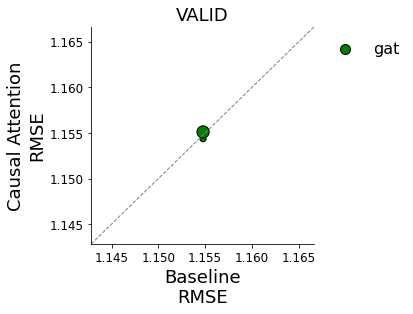

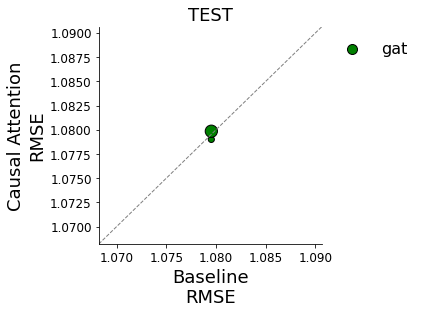

In [ ]:
from ogb.linkproppred import Evaluator

dataset_name = "ogbl-collab"
task = 'lpp'
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=500000)

evaluator = Evaluator(name = dataset_name)

eval_metric = 'hits@50'
params_dict = {'model': ['gatconv'],
               'heads': [3],
               'nl': [1],
               'hd': [10],
               'lc': [0.1],
               'ni': [1]}

save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_lpp/{}/models".format(dataset_name)

results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=1,suffix='interv.ep200',task=task)

eval_set = 'valid'
plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric)

eval_set = 'test'
plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric)


In [ ]:
from collections import Counter

train_loader,valid_loader,test_loader = load_dataloader('ogbl-ddi',batch_size=500000)


plt.hist(Counter(train_loader.data.edge_index[1].data.numpy()).values(),bins=50)
plt.show()

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.linkproppred import Evaluator

dataset_name = "ogbl-ddi"
suffix = 'interv.ep1000.self_loop.early_stop20.ratio'
task = 'lpp'
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=500000)
evaluator = Evaluator(name = dataset_name)
eval_metric = 'hits@20'

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_lpp/{}/models".format(dataset_name)
  
results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/lpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

# OGB Graph Property Prediction

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molfreesolv'
# suffix = 'interv.ep2000.early_stop100.ratio'
suffix = 'interv.ep1000.early_stop20.ratio'
task = 'gpp'
eval_metric = 'kendall'
device = 0
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = KendallEvaluator() #dataset_name) # Evaluator(name = dataset_name)
# evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1,2],
               'hd': [50],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path + "K"):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')
  
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['heads'] >= 1]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-mollipo'
suffix = 'interv.ep3000.early_stop100.ratio'
eval_metric = 'kendall'
device = 0
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = KendallEvaluator() #dataset_name) # Evaluator(name = dataset_name)
# evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)

results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task='gpp')

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_df.to_csv(os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix)),sep='\t')
  
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molesol'
suffix = 'interv.ep1000.early_stop100.ratio'
eval_metric = 'kendall'
device = 0
train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = KendallEvaluator() #dataset_name) # Evaluator(name = dataset_name)
# evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'][0:3],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=0,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molbace'
suffix = 'interv.ep500.weight.early_stop20.ratio'

task = 'gpp'
eval_metric = 'rocauc'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1,2],
               'hd': [50],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path + "K"):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['heads'] >= 1]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molbace'
suffix = 'interv.ep500.weight.early_stop50.ratio'

task = 'gpp'
eval_metric = 'rocauc'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [1,3,5],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'comparison.{}.{}.{}.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['heads'] == 3]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=plot_path)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molhiv'
suffix = 'interv.ep1000.weight.early_stop50.ratio'
task = 'gpp'
eval_metric = 'rocauc'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [3],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=device,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')

plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  plot_df = plot_comparisons(results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=None)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.

In [ ]:
from ogb.graphproppred import Evaluator

dataset_name = 'ogbg-molpcba'
suffix = 'interv.ep50.weight.early_stop20.ratio'
task = 'gpp'
eval_metric = 'ap'
device = 0

train_loader,valid_loader,test_loader = load_dataloader(dataset_name,batch_size=5000)
evaluator = Evaluator(name = dataset_name)

params_dict = {'model': ['gatconv','gatv2conv','transformerconv'],
               'heads': [3],
               'nl': [1],
               'hd': [10,25],
               'lc': [0.1,0.5,1.0,5.0],
               'ni': [5]}

results_dir = '/home/sandbox/workspace/sequence-graphs/results/evaluations'
results_path = os.path.join(results_dir,'{}.{}.eval.tsv'.format(dataset_name,suffix))
if os.path.exists(results_path):
  results_df = pd.read_csv(results_path,sep='\t')
else:
  save_dir = "/home/sandbox/workspace/sequence-graphs/results/ogb_gpp/{}/models".format(dataset_name)
  results_df = evaluate_models(dataset_name,valid_loader,test_loader,evaluator,save_dir,params_dict,
                    eval_metric=eval_metric,device=0,suffix=suffix,task=task)
  results_df.to_csv(results_path,sep='\t')
plot_dir = '/home/sandbox/workspace/sequence-graphs/plots/gpp'
for eval_set in ['test']:
  plot_path = os.path.join(plot_dir,'{}.{}.{}.comparison.png'.format(dataset_name,suffix,eval_set))
  filtered_results_df = results_df[results_df['dim_hidden'] == 25]
  plot_df = plot_comparisons(filtered_results_df,eval_set,eval_metric=eval_metric,
                             alpha_feat='lc',save_path=None)
  print(wilcoxon(plot_df['x'],plot_df['y'],alternative='less'))

PDP: Data is scrubbed due to cell: 55. Last execution time of this cell at 2022-08-24T16:22:53.749832Z exceeds time limit of 21 days for PDP compliance.  Therefore, scrubbing all output cells.Please toggle the Mark PDP Safe switch on the toolbar of the notebook if you are certain the notebook contains no PDP violations to avoid scrubbing in the future. For more information, visit go/nb-pdp.